In [1]:
# Program takes a video input and processes it frame by frame
# Frames are compared to an original frame to detect if boiling is occuring
# Eventually will compare every couple frames apart bc change should be rapid
# As each frame is captured, it is masked to get rid of any part of the image with too much illumination
from skimage.measure import compare_ssim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb
import imutils

### Takes two images and finds SSIM between them
#### Finds threshold of image differences and then finds the contours

In [2]:
# takes two images and finds the SSIM between them
# returns the score back to main
def compareImages(gray1, gray2):
    # compute the Structural Similarity Index (SSIM) between the two
    # images, ensuring that the difference image is returned
    (score, diff) = compare_ssim(gray1, gray2, full=True)
    diff = (diff * 255).astype("uint8")
    
    # threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(gray1, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.rectangle(gray2, (x, y), (x + w, y + h), (0, 0, 255), 2)

    plt.imshow(diff)
    plt.show()
    plt.imshow(thresh)
    plt.show()
    plt.imshow(gray1)
    plt.show()
    plt.imshow(gray2)
    plt.show()
    return score

### Following used as threshold colors for the image mask (found in HSV Calculations notebook)

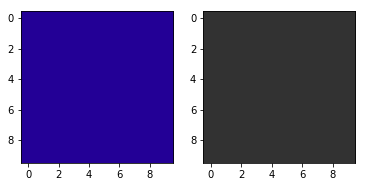

In [3]:
light_blue = (0,0,50)
dark_blue = (180,255,150)
# Normalise to 0 - 1 range for viewing

lo_square = np.full((10, 10, 3), light_blue, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

In [4]:
# returns a masked version of the input image, removes any brightly lit areas
def maskImage(img):
    # will be used to threshold certain colors
    light_blue = (0, 0, 50)
    dark_blue = (180, 255, 150)

    # converts the input image to HSV color scheme
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # masks with 1 if in the range, 0 if not
    mask = cv2.inRange(hsv_img, light_blue, dark_blue)

    return cv2.bitwise_and(img,img,mask=mask)

In [5]:
# returns an undistorted image
def undistort(img, balance=0.0, dim2=None, dim3=None):
    K = np.array(
        [[318.5047565963465, 0.0, 304.72174448074446], [0.0, 318.3070269260298, 234.84280567757642], [0.0, 0.0, 1.0]])
    D = np.array([[-0.041193383831182505], [0.012582938251747337], [-0.026474498577198458], [0.020393209710516367]])
    DIM = (480, 640)  # image dimensions

    dim1 = img.shape[:2][::-1]  # dim1 is the dimension of input image to undistort

    if not dim2:
        dim2 = dim1

    if not dim3:
        dim3 = dim1

    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension
    scaled_K[2][2] = 1.0

    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    return undistorted_img

In [6]:
video = "..\\..\\Desktop\\boiling_short.h264"
print(video)

..\..\Desktop\boiling_short.h264


### Iterates through the input video until the 6000 frame where the water should be boiling, and captures two consecutive frames

In [7]:
cap = cv2.VideoCapture(video)

frameCount = 0 # wait till at a stable beginning
initial = True
while cap.isOpened():
    retTemp, frameTemp = cap.read();

    # if it is the first time then two frames must be recorded
    if initial:
        ret1 = retTemp
        frameOld = frameTemp
        ret2, frameNew = cap.read()
        initial = False
        frameCount += 1
    elif(frameCount == 6000): # should be boiling
        captured = frameNew
        captured2 = frameTemp
        frameCount += 1
        break
        # checks the frame count to see if time to collect a new one
    else:
        ret1 = ret2
        frameOld = frameNew
        ret2 = retTemp
        frameNew = frameTemp
        frameCount += 1

cap.release()

In [8]:
print(frameCount)

6001


### Captured Frames: Undistorted

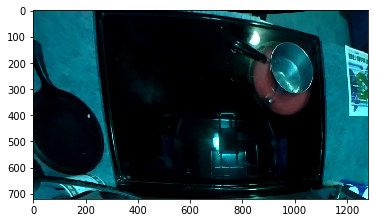

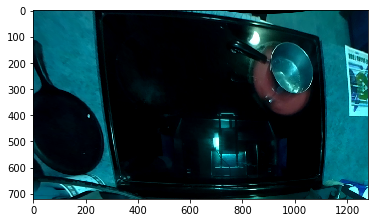

In [9]:
# uses the calibration matrices to process the video
calibrated1_boil = undistort(captured)
calibrated2_boil = undistort(captured2)
plt.imshow(calibrated1_boil)
plt.show()
plt.imshow(calibrated2_boil)
plt.show()

### Captured Frames: Masked Images

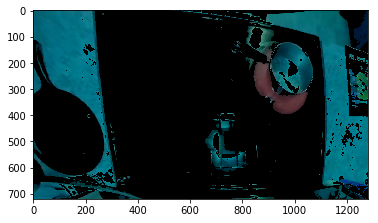

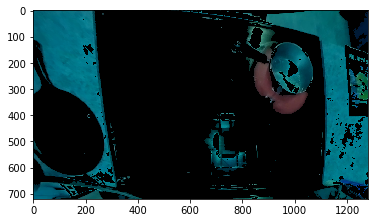

In [10]:
# gets a masked version of the images
mask1 = maskImage(calibrated1_boil)
mask2 = maskImage(calibrated2_boil)

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

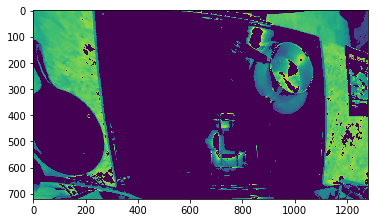

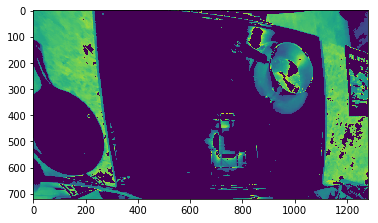

In [11]:
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

### Captured Frames: Showing the difference and thresh between the two images

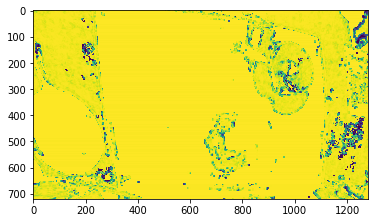

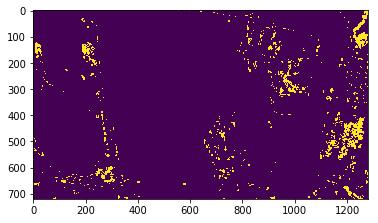

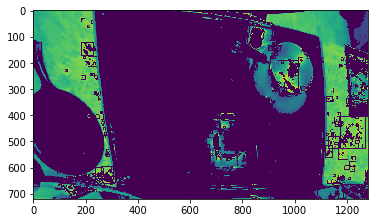

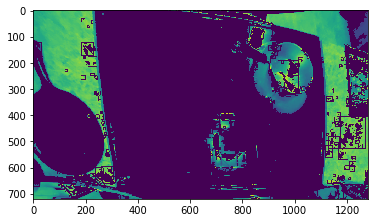


SSIM: 0.9569965443218733


In [12]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

In [13]:
cap = cv2.VideoCapture(video)

frameCount = 0 # wait till at a stable beginning
initial = True
while cap.isOpened():
    retTemp, frameTemp = cap.read();

    # if it is the first time then two frames must be recorded
    if initial:
        ret1 = retTemp
        frameOld = frameTemp
        ret2, frameNew = cap.read()
        initial = False
        frameCount += 1
    elif(frameCount == 4000): # should not be boiling yet
        captured = frameNew
        captured2 = frameTemp
        frameCount += 1
        break
        # checks the frame count to see if time to collect a new one
    else:
        ret1 = ret2
        frameOld = frameNew
        ret2 = retTemp
        frameNew = frameTemp
        frameCount += 1

cap.release()

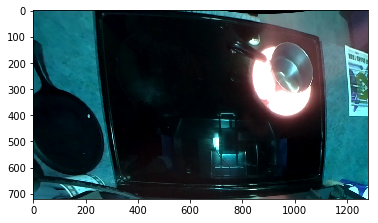

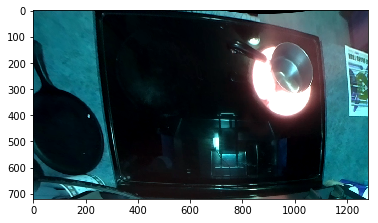

In [14]:
# uses the calibration matrices to process the video
calibrated1_noboil = undistort(captured)
calibrated2_noboil = undistort(captured2)
plt.imshow(calibrated1_noboil)
plt.show()
plt.imshow(calibrated2_noboil)
plt.show()

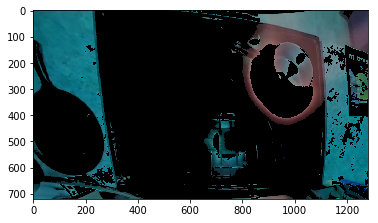

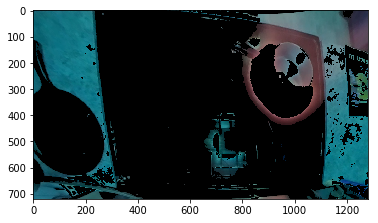

In [15]:
# gets a masked version of the images
mask1 = maskImage(calibrated1_noboil)
mask2 = maskImage(calibrated2_noboil)

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

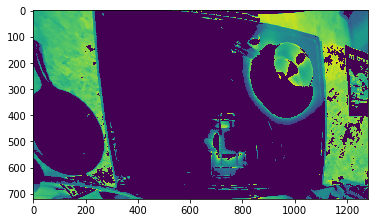

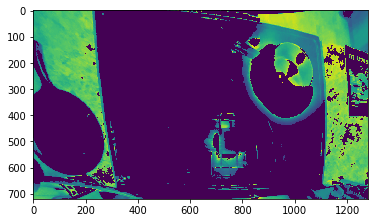

In [16]:
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

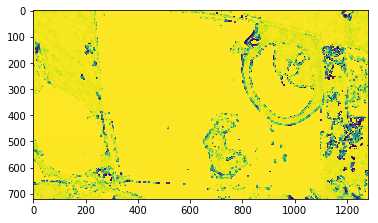

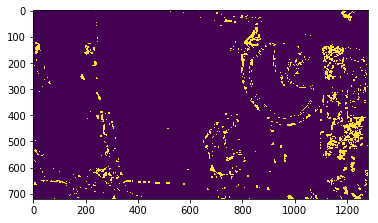

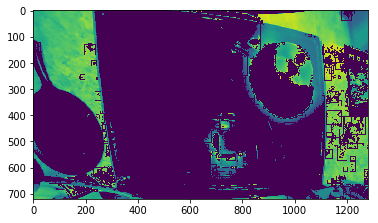

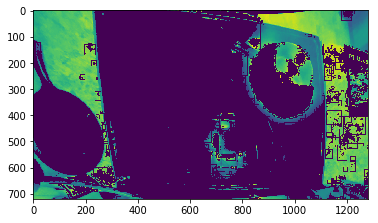


SSIM: 0.9520580205993932


In [17]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

# New set of tests with cropped pot and no mask being applied

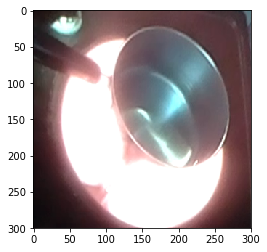

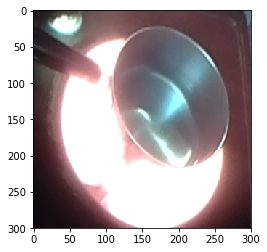

In [41]:
crop1_noboil = calibrated1_noboil[100:400, 800:1100]
plt.imshow(crop1_noboil)
plt.show()
crop2_noboil = calibrated2_noboil[100:400, 800:1100]
plt.imshow(crop2_noboil)
plt.show()

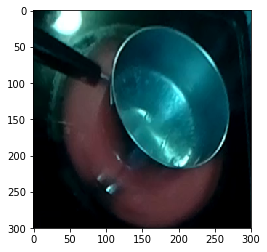

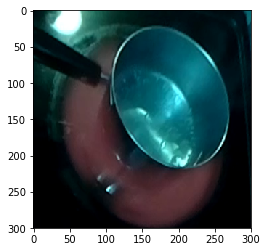

In [52]:
crop1_boil = calibrated1_boil[100:400, 800:1100]
plt.imshow(crop1_boil)
plt.show()
crop2_boil = calibrated2_boil[100:400, 800:1100]
plt.imshow(crop2_boil)
plt.show()

### Comparing SSIM between cropped pots - no boil

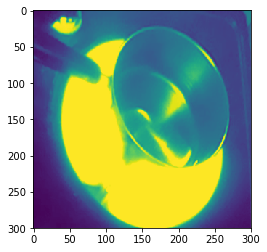

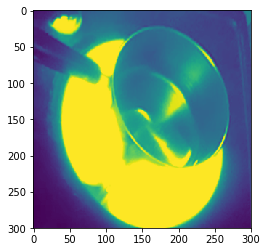

In [55]:
# converts the images images to grayscale
gray1 = cv2.cvtColor(crop1_noboil, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(crop2_noboil, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

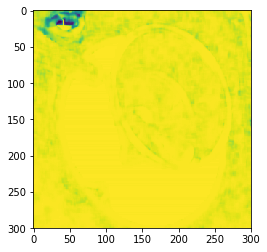

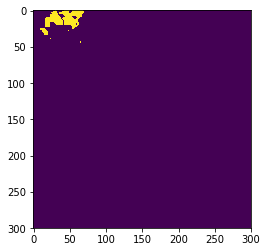

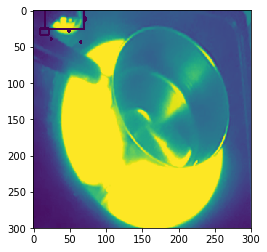

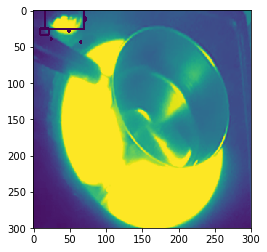


SSIM: 0.9764386963137828


In [56]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

### Comparing SSIM between cropped pots - boil

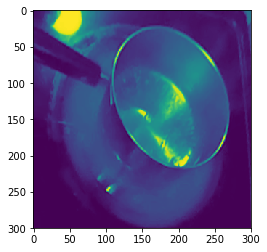

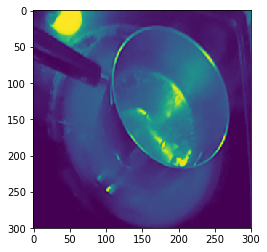

In [58]:
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(crop1_boil, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(crop2_boil, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

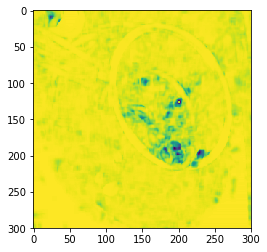

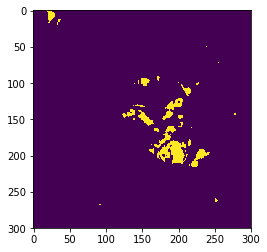

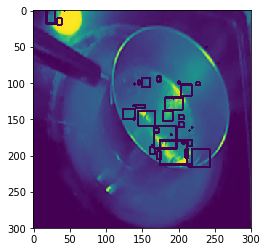

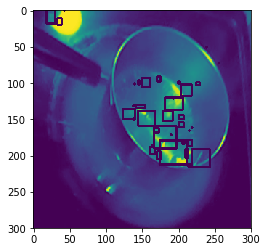


SSIM: 0.9622497938681841


In [59]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

#### Seems like it does recognize the difference in the images in the pot when the burner shows a cropped picture. It works better with no mask applied than with the mask.

# Same tests as above, but with a mask applied to show the difference

### Comparing SSIM between cropped pots - no boil

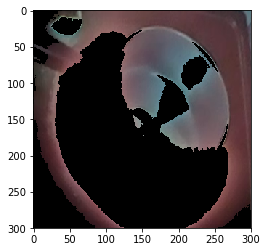

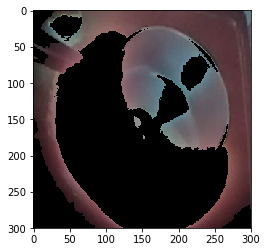

In [60]:
# gets a masked version of the images
mask1 = maskImage(crop1_noboil)
mask2 = maskImage(crop2_noboil)

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

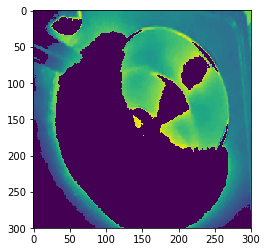

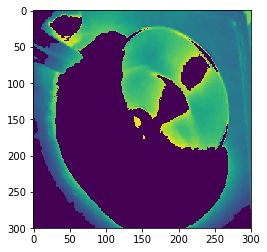

In [62]:
# converts the images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

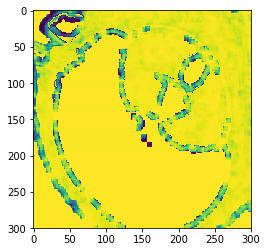

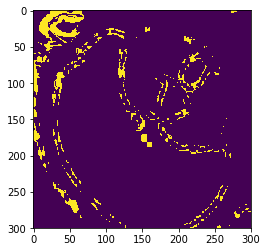

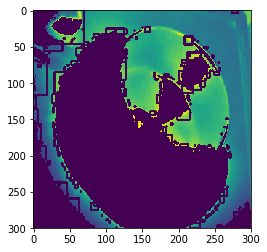

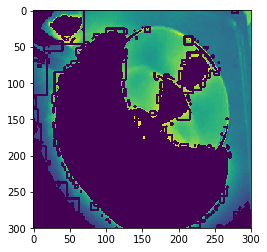


SSIM: 0.9293432558069236


In [63]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

### Comparing SSIM between cropped pots - boil

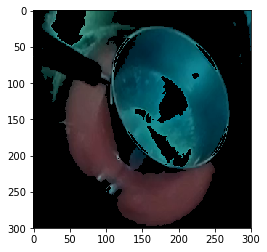

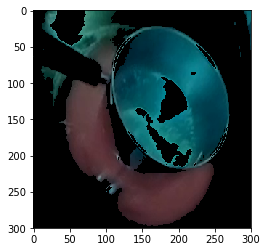

In [64]:
# gets a masked version of the images
mask1 = maskImage(crop1_boil)
mask2 = maskImage(crop2_boil)

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

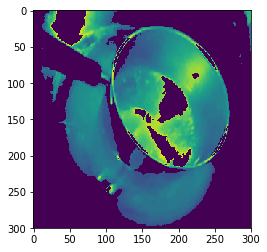

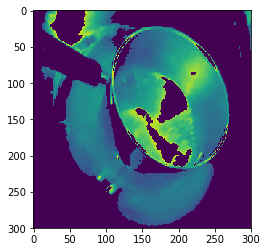

In [65]:
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

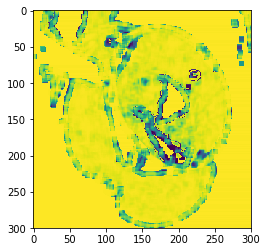

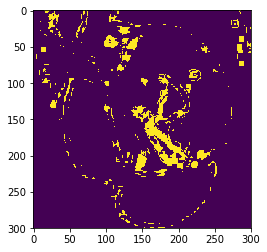

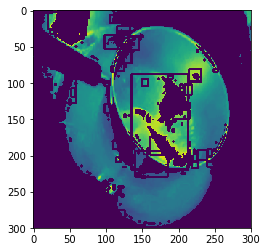

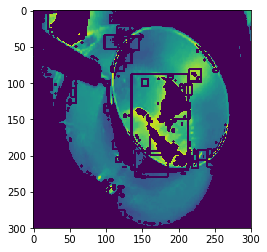


SSIM: 0.9215716326357093


In [66]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

#### With the way the mask is now, there is a lot of noise that interferes with the bubbles being read. If applied some of the techniques been showed this could potentially be fixed? If not, the cropped method seems to be more reliable as it removes a lot of the unecessary background noise in the images.